# How well do jobs and skills pay for Data Scientists?

Compare salary distributions across common data roles and then focus on how skills relate to pay for Data Scientist postings.

## Import Libraries and Data

In [17]:
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('E:/Projects/Python_Data_Project/job_postings_flat_cleaned.csv')

## Salary Distribution by Job Title

Keep only postings with reported salary and select the most common roles for comparison.

In [18]:
df_filtered = df.dropna(subset=['salary_year_avg'])

job_titles = df_filtered['job_title_short'].value_counts().index[:6].tolist()

df_top6 = df_filtered[df_filtered['job_title_short'].isin(job_titles)]

job_order = df_top6.groupby('job_title_short')['salary_year_avg'].median().sort_values(ascending=False).index

job_titles

['Data Analyst',
 'Data Scientist',
 'Data Engineer',
 'Senior Data Scientist',
 'Senior Data Analyst',
 'Senior Data Engineer']

## Plot Salary Distributions

Plot salary distributions across the selected roles, including outliers.

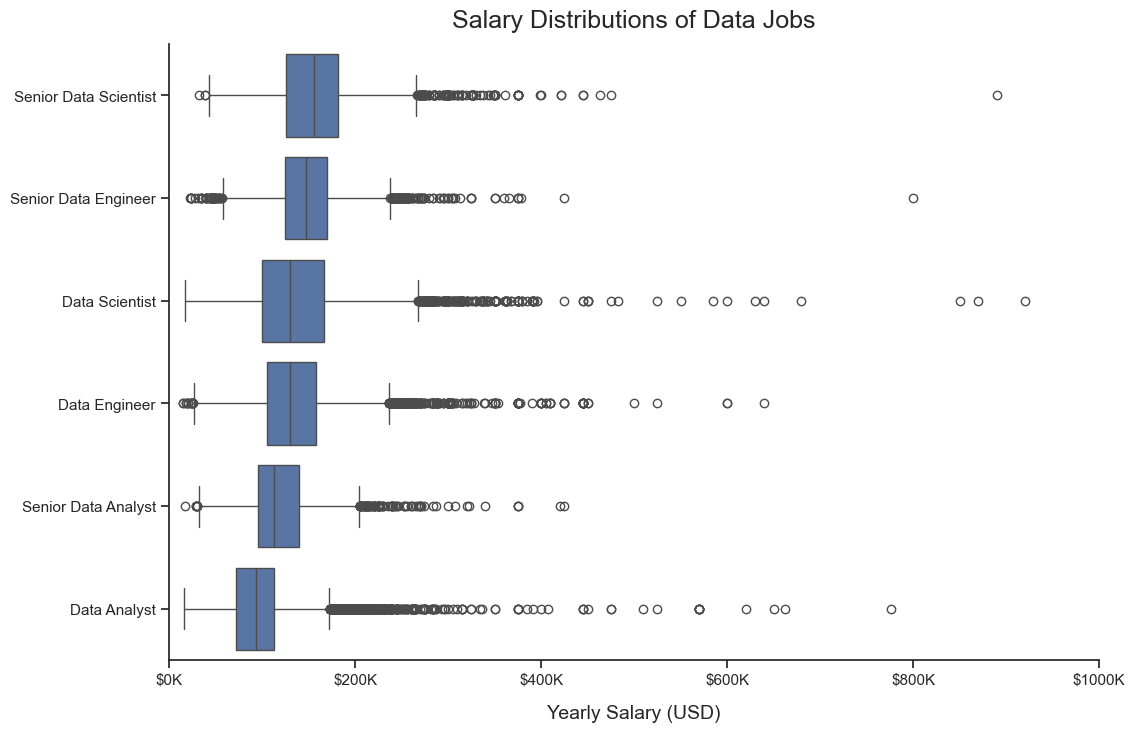

In [19]:
plt.figure(figsize=(12, 8))

sns.boxplot(data=df_top6, x='salary_year_avg', y='job_title_short', order=job_order)
sns.set_theme(style='ticks')
sns.despine()

plt.title('Salary Distributions of Data Jobs', fontsize=18, pad=12)
plt.xlabel('Yearly Salary (USD)', fontsize=14, labelpad=12)
plt.ylabel('')
plt.xlim(0, 1000000) 
ticks_x = plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.show()

## Plot Salary Distributions - Closer Look

Plot the same salary distributions without outliers to make typical ranges easier to compare.

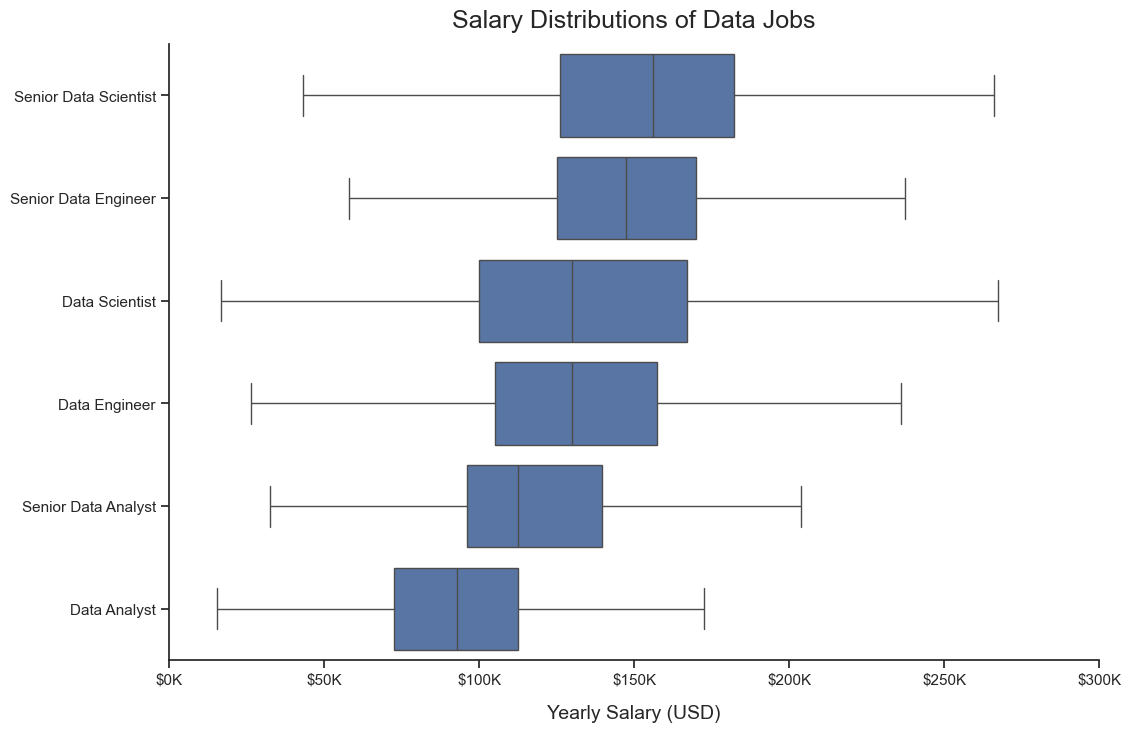

In [20]:
plt.figure(figsize=(12, 8))

sns.boxplot(data=df_top6, x='salary_year_avg', y='job_title_short', order=job_order, showfliers=False)
sns.set_theme(style='ticks')
sns.despine()

plt.title('Salary Distributions of Data Jobs', fontsize=18, pad=12)
plt.xlabel('Yearly Salary (USD)', fontsize=14, labelpad=12)
plt.ylabel('')
plt.xlim(0, 300000) 
ticks_x = plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.show()

## Investigate Median Salary Vs Skill for Data Scientists

Filter to Data Scientist postings with salary and non-empty skills, then explode skills to a skill-level dataset.

In [21]:
df["job_skills"] = df["job_skills"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df_DS = df[df["job_title_short"] == "Data Scientist"].copy()

# keep only postings with reported salary
df_DS = df_DS.dropna(subset=["salary_year_avg"])

# keep only postings where job_skills is a non-empty list
mask_skills = df_DS["job_skills"].apply(lambda x: isinstance(x, list) and len(x) > 0)

# coverage sanity-check (how much salary data also has skills captured)
total_salary = len(df_DS)
with_skills = mask_skills.sum()
missing_skills_pct = (1 - with_skills / total_salary) * 100

print(f"DS postings with salary: {total_salary:,}")
print(f"DS postings with salary AND skills: {with_skills:,} ({missing_skills_pct:.1f}% missing/empty job_skills)")

df_DS = df_DS[mask_skills].copy()

# explode skills (one row = one skill in a posting)
df_DS = df_DS.explode("job_skills")

df_DS[["salary_year_avg", "job_skills"]].head(5)

DS postings with salary: 16,547
DS postings with salary AND skills: 13,542 (18.2% missing/empty job_skills)


,salary_year_avg,job_skills
56,110000.0,python
56,110000.0,sql
56,110000.0,tableau
56,110000.0,excel
231,120531.0,java


## Determine The Highest Paid Skills and Most Demanded Skills

- Compute and compare:

    - Top-paying skills (median salary, skills with count >= 100)

    - Most in-demand skills (top 10 by posting count)

- For the in-demand list, the chart displays the median salary of those top-demand skills to make salary comparison consistent.

In [22]:
# Top-paying skills for Data Scientists (only skills appearing in at least 100 postings)
df_DS_top_pay = (
    df_DS.groupby("job_skills")["salary_year_avg"]
        .agg(count="count", median="median")
        .query("count >= 100")
        .sort_values(by="median", ascending=False)
        .head(10)
)
df_DS_top_pay

,count,median
job_skills,,
hugging face,188,173500.0
airflow,377,154500.0
scala,927,150000.0
perl,123,150000.0
pytorch,1675,150000.0
bigquery,324,145000.0
tensorflow,1984,145000.0
express,289,144000.0
kubernetes,449,143721.5


In [23]:
df_DS_skills = df_DS.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DS_skills = df_DS_skills.head(10).sort_values(by='median', ascending=False)

df_DS_skills

,count,median
job_skills,,
pytorch,1675,150000.00
tensorflow,1984,145000.00
spark,2173,142500.00
aws,2632,140000.00
sql,7790,135000.00
python,10717,135000.00
azure,1912,132906.25
r,5752,132556.00
tableau,2858,125000.00


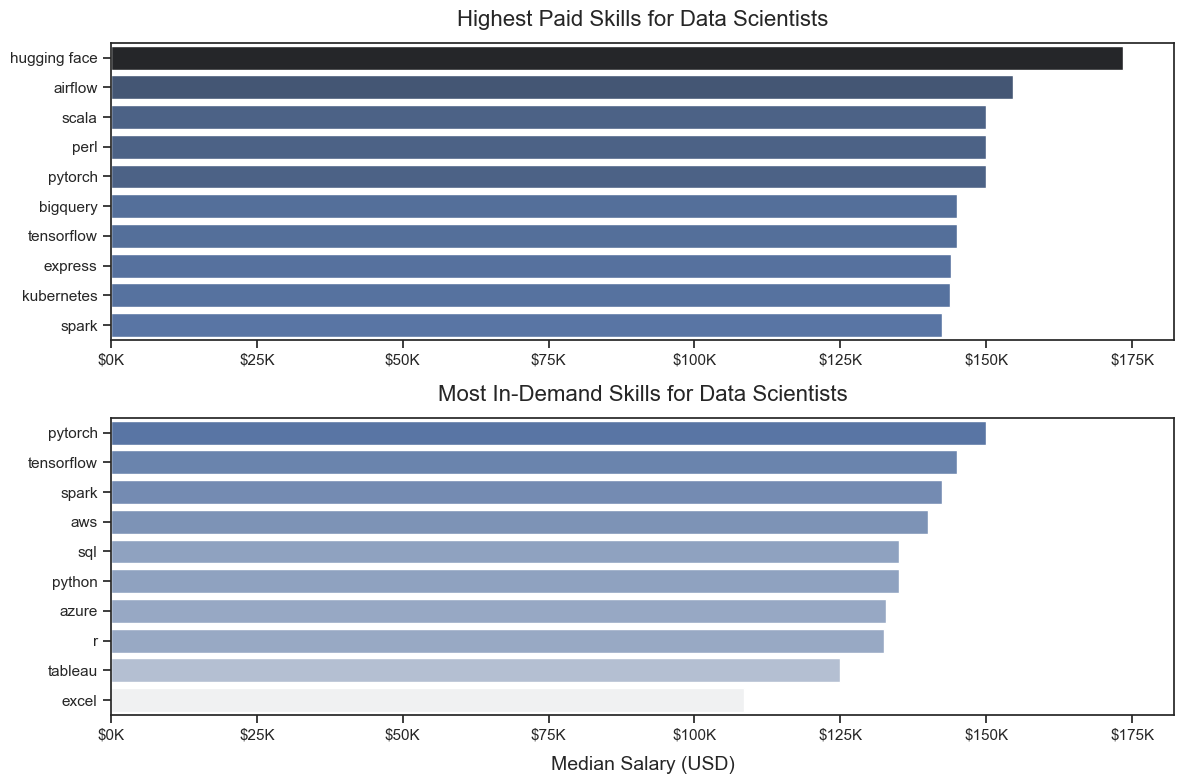

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.barplot(data=df_DS_top_pay, x='median', y=df_DS_top_pay.index, hue='median', ax=ax[0], palette='dark:b_r')
ax[0].legend().remove()

ax[0].set_title('Highest Paid Skills for Data Scientists', fontsize=16, pad=12)
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))

sns.barplot(data=df_DS_skills, x='median', y=df_DS_skills.index, hue='median', ax=ax[1], palette='light:b')
ax[1].legend().remove()

ax[1].set_title('Most In-Demand Skills for Data Scientists', fontsize=16, pad=12)
ax[1].set_ylabel('')
ax[1].set_xlabel('Median Salary (USD)', fontsize=14, labelpad=10)
ax[1].set_xlim(ax[0].get_xlim())
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))

sns.set_theme(style='ticks')
plt.tight_layout()
plt.show()